In [1]:
import pickle

from src.models import HLGC
from src.data import Newsgroups

In [2]:
#data = pickle.load(open('data/cifar100-resnet152.pickle', 'rb'))
data = pickle.load(open('data/20newsgroups.pickle', 'rb'))

In [3]:
hparams = {
    'n_features' : len(data['train']['features'][0]),
    'hidden_dim' : 128,
    'latent_dims' : [50],
    'batch_size' : 32,
    'lr' : 0.001,
    'dropout' : 0.5,
    'n_epochs' : 25,
    'early_stopping_epochs' : 5,
    'latent_loss_weight' : 1.0,
    'recon_loss_weight' : 1.0,
    'l1_lambda' : 0.001, 
    'val_split' : 0.1, 
    'display_interval' : 200
}

In [4]:
model = HLGC(
    len(data['flat_label_dict']), hparams['n_features'], hparams['latent_dims'], hidden_dim=hparams['hidden_dim'], 
    dropout_rate=hparams['dropout'], batch_size=hparams['batch_size'], lr=hparams['lr'], 
    n_epochs=hparams['n_epochs'], class_weights=data['class_weights'], recon_loss_weight=hparams['recon_loss_weight'], 
    latent_loss_weight=hparams['latent_loss_weight'], 
    l1_lambda=hparams['l1_lambda'], display_interval=hparams['display_interval'], 
    early_stopping_epochs=hparams['early_stopping_epochs'], label_dict=data['flat_label_dict']
)

No validation data provided, using 10.0% of train data
[0,     1] loss - (total : 13.310925, clf : 2.993112, support : 2.987690, recon : 3.905104, latent : 2.971952), acc - (clf : 0.062500, recon : 0.062500)
[0,   200] loss - (total : 7.437936, clf : 1.627821, support : 1.835969, recon : 1.920459, latent : 1.952502), acc - (clf : 0.937500, recon : 0.187500)
[ Eval ] loss - (total : 5.783751, clf : 1.111861, support : 1.680756, recon : 1.252872, latent : 1.609010), acc - (clf : 0.858657, support : 0.310954, recon : 0.343640)
talk.religion.misc : [6]
-----
comp.sys.ibm.pc.hardware : [13]
sci.crypt : [13]
-----
alt.atheism : [18]
sci.space : [18]
soc.religion.christian : [18]
talk.politics.guns : [18]
-----
comp.graphics : [19]
misc.forsale : [19]
rec.sport.baseball : [19]
-----
sci.med : [32]
talk.politics.mideast : [32]
-----
rec.sport.hockey : [34]
-----
comp.os.ms-windows.misc : [42]
comp.sys.mac.hardware : [42]
comp.windows.x : [42]
rec.autos : [42]
rec.motorcycles : [42]
sci.electro

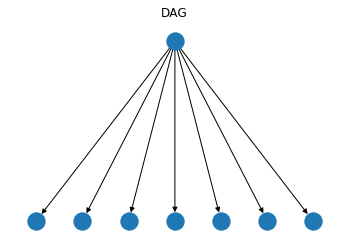

[1,   400] loss - (total : 5.197770, clf : 0.960737, support : 1.501637, recon : 0.995554, latent : 1.599218), acc - (clf : 0.875000, recon : 0.531250)
[1,   600] loss - (total : 3.786278, clf : 0.451365, support : 1.432269, recon : 0.399891, latent : 1.361374), acc - (clf : 0.875000, recon : 0.843750)
[ Eval ] loss - (total : 3.655590, clf : 0.549107, support : 1.407190, recon : 0.234482, latent : 1.324900), acc - (clf : 0.891343, support : 0.372792, recon : 0.878975)
misc.forsale : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.autos : [19]
rec.motorcycles : [19]
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [25]
-----
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


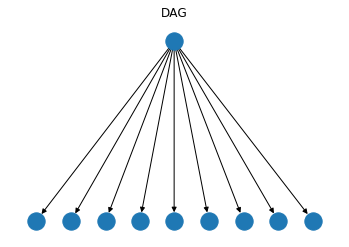

[2,   800] loss - (total : 2.668301, clf : 0.214580, support : 1.089151, recon : 0.192713, latent : 1.034057), acc - (clf : 1.000000, recon : 0.937500)
[ Eval ] loss - (total : 3.517685, clf : 0.403918, support : 1.438965, recon : 0.144740, latent : 1.398153), acc - (clf : 0.913428, support : 0.372792, recon : 0.944346)
misc.forsale : [6]
rec.autos : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.motorcycles : [19]
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


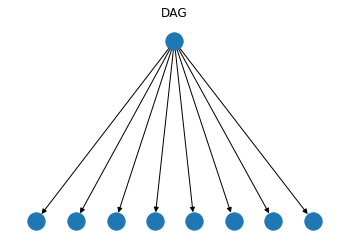

[3,  1000] loss - (total : 3.321711, clf : 0.213022, support : 1.236703, recon : 0.402030, latent : 1.339328), acc - (clf : 0.968750, recon : 0.906250)
[3,  1200] loss - (total : 3.242505, clf : 0.145199, support : 1.395961, recon : 0.164597, latent : 1.411436), acc - (clf : 1.000000, recon : 0.968750)
[ Eval ] loss - (total : 3.504432, clf : 0.349352, support : 1.462091, recon : 0.115618, latent : 1.453194), acc - (clf : 0.908127, support : 0.361307, recon : 0.959364)
misc.forsale : [6]
rec.autos : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.motorcycles : [19]
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


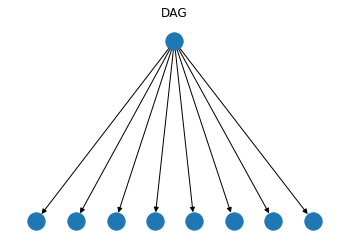

[4,  1400] loss - (total : 2.892578, clf : 0.089662, support : 1.195928, recon : 0.261036, latent : 1.224775), acc - (clf : 1.000000, recon : 0.812500)
[ Eval ] loss - (total : 3.501256, clf : 0.325718, support : 1.477305, recon : 0.124455, latent : 1.457811), acc - (clf : 0.915194, support : 0.391343, recon : 0.940813)
misc.forsale : [6]
rec.autos : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
-----
rec.motorcycles : [19]
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
talk.religion.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


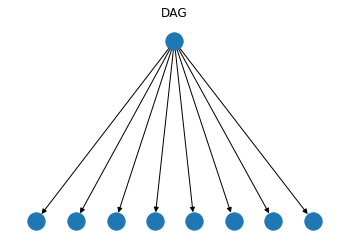

[5,  1600] loss - (total : 2.925769, clf : 0.090322, support : 1.276773, recon : 0.106428, latent : 1.336493), acc - (clf : 0.968750, recon : 0.906250)
[5,  1800] loss - (total : 2.917463, clf : 0.082629, support : 1.243581, recon : 0.094881, latent : 1.384306), acc - (clf : 1.000000, recon : 0.843750)
[ Eval ] loss - (total : 3.568580, clf : 0.316110, support : 1.505266, recon : 0.141326, latent : 1.496309), acc - (clf : 0.913428, support : 0.355124, recon : 0.943463)
misc.forsale : [6]
rec.autos : [6]
rec.motorcycles : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
-----
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
talk.religion.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


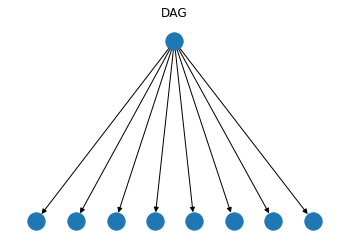

[6,  2000] loss - (total : 2.867290, clf : 0.052409, support : 1.222121, recon : 0.198503, latent : 1.285769), acc - (clf : 1.000000, recon : 0.843750)
[6,  2200] loss - (total : 3.553477, clf : 0.051099, support : 1.547657, recon : 0.144530, latent : 1.704746), acc - (clf : 1.000000, recon : 0.906250)
[ Eval ] loss - (total : 3.586774, clf : 0.312910, support : 1.524489, recon : 0.119761, latent : 1.524919), acc - (clf : 0.912544, support : 0.366608, recon : 0.934629)
misc.forsale : [6]
rec.autos : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.motorcycles : [19]
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


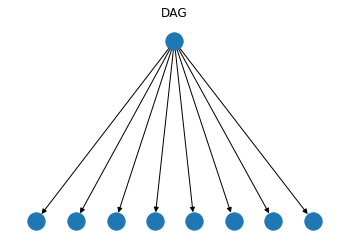

[7,  2400] loss - (total : 2.731975, clf : 0.008565, support : 1.203053, recon : 0.126272, latent : 1.292076), acc - (clf : 1.000000, recon : 0.906250)
[ Eval ] loss - (total : 3.591565, clf : 0.312042, support : 1.536020, recon : 0.145458, latent : 1.498641), acc - (clf : 0.909894, support : 0.345406, recon : 0.929329)
rec.autos : [6]
rec.motorcycles : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
misc.forsale : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


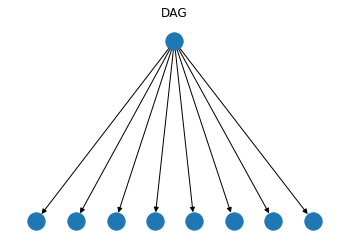

[8,  2600] loss - (total : 2.981187, clf : 0.009522, support : 1.334009, recon : 0.108579, latent : 1.430153), acc - (clf : 1.000000, recon : 0.937500)
[8,  2800] loss - (total : 2.720130, clf : 0.007232, support : 1.219470, recon : 0.118688, latent : 1.277771), acc - (clf : 1.000000, recon : 0.937500)
[ Eval ] loss - (total : 3.615033, clf : 0.314750, support : 1.536253, recon : 0.108640, latent : 1.559322), acc - (clf : 0.912544, support : 0.384276, recon : 0.942580)
misc.forsale : [6]
rec.autos : [6]
rec.motorcycles : [6]
sci.electronics : [6]
-----
comp.os.ms-windows.misc : [13]
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
-----
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
talk.religion.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


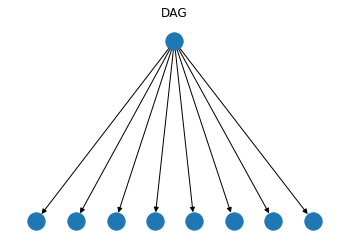

[9,  3000] loss - (total : 2.452267, clf : 0.011686, support : 1.139982, recon : 0.066551, latent : 1.140077), acc - (clf : 1.000000, recon : 0.937500)
[ Eval ] loss - (total : 3.601570, clf : 0.320860, support : 1.534682, recon : 0.131689, latent : 1.522841), acc - (clf : 0.913428, support : 0.371025, recon : 0.931979)
misc.forsale : [6]
rec.autos : [6]
rec.motorcycles : [6]
sci.electronics : [6]
-----
comp.sys.ibm.pc.hardware : [13]
comp.sys.mac.hardware : [13]
-----
alt.atheism : [18]
soc.religion.christian : [18]
talk.politics.mideast : [18]
talk.religion.misc : [18]
-----
rec.sport.baseball : [19]
rec.sport.hockey : [19]
-----
talk.politics.guns : [32]
talk.politics.misc : [32]
-----
sci.med : [34]
-----
comp.graphics : [42]
comp.os.ms-windows.misc : [42]
comp.windows.x : [42]
-----
sci.crypt : [45]
sci.space : [45]


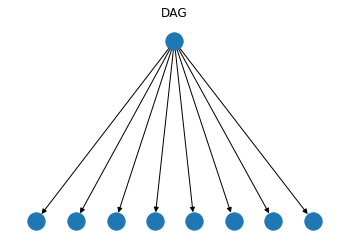

Training complete!


In [5]:
model.fit(data['train']['features'], data['train']['flat_labels']) #, save_dir='train_results/cifar100')